In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore
from matplotlib.colors import LogNorm, Normalize
import os
import pycwt as cwt
import pickle

In [2]:
FS = 4 # E4 sampling rate

SAVE_CWT_FOLDER = '/media/bayesian-posterior/sdc/sensecode_data/all_freq_eda_cwt_data/'

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

# DAYS_ARRAY = np.asarray([0.5, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31])
# FREQ_ARRAY = 1 / (DAYS_ARRAY * 24 * 60 * 60) # for morlet
# FREQ_NAMES = ["{:.1f}".format(day)+' Day(s)' for day in DAYS_ARRAY]

# PANDAS_RESAMPLE_RATE = "{:.2f}".format(1/4)+'S' # find missing samples (datetime)
PANDAS_RESAMPLE_RATE = 'T'

# wavelet and filter variables                    
mother = cwt.Morlet(6)
order = 2; fs=60


In [3]:
def plot_signal(df_eda,
                fs,
                label,
                ylim = None):
    
    plt.figure(figsize=(15, 5))
    
    t = df_eda.index.to_series()
    x = df_eda[label]
    xtick_freq = int(fs*60*60*24*7)
    
    plt.plot(range(len(t)), x, label = label)
    plt.legend(loc=1)
    plt.xticks(range(len(t))[::xtick_freq], t[::xtick_freq], rotation='vertical')

    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Date')
    plt.ylabel('EDA [uS]')
    plt.grid()

In [4]:
def remove_artifacts_and_interpolate(df_eda, 
                     fs, 
                     pandas_resample_rate,
                                     clip_rate,
                                     interpolate_method = 'time',
                                     z_score = True):
    
    df_eda_without_artifacts = df_eda.resample(pandas_resample_rate).median()
    
    # df_eda_without_artifacts['hour'] = df_eda_without_artifacts.index.to_series().apply(lambda x : x.hour)    
    # df_eda_without_artifacts['eda'] = df_eda_without_artifacts.groupby('hour', group_keys=False)['eda'].apply(lambda x: x.fillna(x.mean()))
    
    df_eda_without_artifacts.fillna(df_eda_without_artifacts['eda'].median(), inplace=True)
        
    if clip_rate > 0:
        upper_quantile = df_eda_without_artifacts['eda'].quantile(clip_rate)
        print('EDA upper quantile:', upper_quantile)
        df_eda_without_artifacts.loc[df_eda_without_artifacts['eda'] >= upper_quantile, 'eda'] = upper_quantile
    
    if z_score:
        print('z-scored')
        df_eda_without_artifacts['eda'] = zscore(df_eda_without_artifacts['eda'])
        

    return df_eda_without_artifacts

In [5]:
# def apply_fir(eda: np.ndarray,
#               fs,
#               cutoff,
#               filter_type, # bandpass, lowpass, highpass, bandstop
#               transition_band,
#               window) -> np.ndarray:
    
#     if window == 'hann' or window == 'hamming' or window == 'bartlett':
#         M = int(4 * fs / transition_band)
#     elif window == 'blackman':
#         M = int(6 * fs / transition_band)
#     else:
#         raise ValueError('Length estimation for this window not implemented')
        
#     # print('Using ' + window + ' window for ' + filter_type + ' FIR filter.')
#     h = signal.firwin(numtaps = M, 
#                       cutoff = cutoff,
#                       fs = fs,
#                       pass_zero = filter_type,
#                       window = window)
    
#     eda = np.squeeze(eda)
#     return signal.lfilter(h, [1.0], eda) 
#     # return signal.filtfilt(h, [1.0], eda) # avoid phase shift of single filter

In [6]:
# def morlet_wavelet(eda: np.ndarray, 
#                    fs, 
#                    freq_arr, 
#                    w = 6):
    
#     widths = w * fs / (2 * freq_arr * np.pi)
#     cwtm = signal.cwt(eda, signal.morlet2, widths, w = w)
    
#     return np.abs(cwtm)


In [7]:
all_peaks_dict = {}
all_power_dict = {}

for file in os.listdir(DATA_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("worn_left.h5"):
        
        subject = filename.split('_')[0]
        eda_filepath = DATA_FOLDER_PATH+filename
        
        print(eda_filepath, subject)
        
        df_eda = pd.read_hdf(eda_filepath)

        # plot_signal(df_eda = df_eda, label = 'eda', fs = FS)
        df_eda_without_artifacts = remove_artifacts_and_interpolate(df_eda = df_eda, 
                                                                    fs = FS, 
                                                                    pandas_resample_rate = PANDAS_RESAMPLE_RATE, 
                                                                    clip_rate = 0, 
                                                                    z_score = True)
        
        delta = df_eda_without_artifacts.index[-1] - df_eda_without_artifacts.index[0]
        n = delta.total_seconds()/3600/2
        freqs = np.append(np.arange(11, 31.2, 1.2), np.arange(31.2, 48, 2.4))
        freqs = np.append(freqs, np.arange(2.2*24, 4*24 + 4.8, 4.8))
        freqs = np.append(freqs, np.arange(5*24, int(n), 12))
        freqs = (1/freqs)
        
        # wavelet
        y = df_eda_without_artifacts.resample('T').median()['eda'].to_numpy()
        dt = 1/60
        alpha, _, _ = cwt.ar1(y) # lag 1 autocorrelation for significance
        wave, scales, freqs, coi, fft, fftfreqs = cwt.cwt(signal = y, dt = dt, wavelet = mother, freqs = freqs)
        power = np.abs(wave) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        
        glbl_power = power.mean(axis=1)
        dof = y.size - scales  # Correction for padding at edges
        var = y.std()**2
        glbl_signif, tmp = cwt.significance(var, dt, scales, 1, alpha, significance_level=0.99, dof=dof, wavelet=mother)
        signif, fft_theor = cwt.significance(1.0, dt, scales, 0, alpha, significance_level=0.99, wavelet=mother)
        
        # Find peaks that are significant
        xpeaks = []; powers = []
        ind_peaks = signal.find_peaks(var * glbl_power)[0]
        for i in ind_peaks:
            peak = [var * glbl_power > glbl_signif][0][i]
            if peak:
                if period[i] not in xpeaks:
                    xpeaks.append(period[i])
                    powers.append([var * glbl_power][0][i])

        # keep only stongest peak if there is a peak within +/- 33% of another peak
        # xpeaks = np.array(xpeaks)  
        # new_xpeaks = {}
        # for peak in xpeaks:
        #     ints2 = np.where(np.logical_and(xpeaks>=peak-0.33*peak, xpeaks<=peak+0.33*peak))
        #     # is the peak in another peaks BP filter?
        #     other = [i for i,p in enumerate(xpeaks) if peak >= p - 0.33*p and peak <= p + 0.33*p]
        #     ints2 = set(np.array(list(ints2[0]) + other))
        #     if len(ints2):
        #         # if there is a peak within +/- 33%, check the power of it, choose highest
        #         max_peak = xpeaks[[var * glbl_power][0].tolist().index(np.max([[var * glbl_power][0][i] for i in ints2]))]
        #         new_xpeaks[peak] = max_peak
        # xpeaks = sorted(set(new_xpeaks.values()))
        
        assert len(xpeaks) == len(powers)
        print(xpeaks)
        all_peaks_dict[subject] = xpeaks
        all_power_dict[subject] = powers


/media/bayesian-posterior/sdc/sensecode_data/SP22_eda_worn_left.h5 SP22
z-scored
[24.199999999999992, 36.0, 76.79999999999998, 95.99999999999997, 168.0, 240.0, 432.0, 732.0]
/media/bayesian-posterior/sdc/sensecode_data/SP69_eda_worn_left.h5 SP69
z-scored
[12.2, 40.80000000000001, 62.39999999999999, 95.99999999999997, 192.0, 371.99999999999994, 732.0]
/media/bayesian-posterior/sdc/sensecode_data/SP28_eda_worn_left.h5 SP28
z-scored
[12.2, 24.199999999999992, 732.0]
/media/bayesian-posterior/sdc/sensecode_data/SP21_eda_worn_left.h5 SP21
z-scored
[120.0, 276.0, 564.0, 732.0]
/media/bayesian-posterior/sdc/sensecode_data/SP59_eda_worn_left.h5 SP59
z-scored
[15.799999999999995, 24.199999999999992, 36.0, 52.80000000000001, 81.6, 132.0, 204.0, 432.0]
/media/bayesian-posterior/sdc/sensecode_data/SP72_eda_worn_left.h5 SP72
z-scored
[24.199999999999992, 168.0]
/media/bayesian-posterior/sdc/sensecode_data/SP71_eda_worn_left.h5 SP71
z-scored
[25.39999999999999, 43.20000000000001, 86.39999999999998, 

In [8]:
# file1 = open('all_peaks_eda_dict.pkl', 'wb')
# pickle.dump(all_peaks_dict, file1)

# file2 = open('all_power_eda_dict.pkl', 'wb')
# pickle.dump(all_power_dict, file2)

In [9]:
def plot_peak_power_dist(all_peaks_dict, all_power_dict):
    
    all_peaks_list = []
    avg_power_dict = {}
    
    for subject, peaks in all_peaks_dict.items():
        
        all_peaks_list += all_peaks_dict[subject]

        for idx, p in enumerate(all_power_dict[subject]):
            rounded_peak = round(peaks[idx], 0)
            if rounded_peak in avg_power_dict.keys():
                avg_power_dict[rounded_peak].append(p)
            else:
                avg_power_dict[rounded_peak] = [p]
    
    rounded_peak_vec = list(avg_power_dict.keys())
    avg_power_vec = []
    sd_power_vec = []
    for rounded_peak in rounded_peak_vec:
        avg_power_vec.append(np.mean(avg_power_dict[rounded_peak]))
        sd_power_vec.append(np.std(avg_power_dict[rounded_peak]))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    ax1.hist(all_peaks_list, bins = 100, color = 'red', alpha = 0.5)
    ax1.set_xlabel('Period [Hour]')
    ax1.set_ylabel('Number of Subjects')
    ax1.grid(True)
    
    vline_labels = ['1 Day', '7 Days', '30 Days']
    vline_positions = [24, 24*7, 24*30]
    for label, position in zip(vline_labels, vline_positions):
        ax1.axvline(position, color = 'green', label = label)
    ax1.legend(loc=1)
    ax1.set_title('Number of subjects with significant peaks at different periods')
    
    ax2.errorbar(rounded_peak_vec, 
                 avg_power_vec, 
                 fmt = 'o',
                 yerr = sd_power_vec, 
                 capsize = 5,
                 lw = 1,
                 label ='1 SD')
    
    ax2.set_xlabel('Period [Hour]')
    ax2.set_ylabel('Average Power')

    for label, position in zip(vline_labels, vline_positions):
        ax2.axvline(position, color = 'green', label = label)
    ax2.legend(loc=1)
    ax2.set_title('Average power of significant peaks at different periods over all subjects')
    ax2.grid(True)


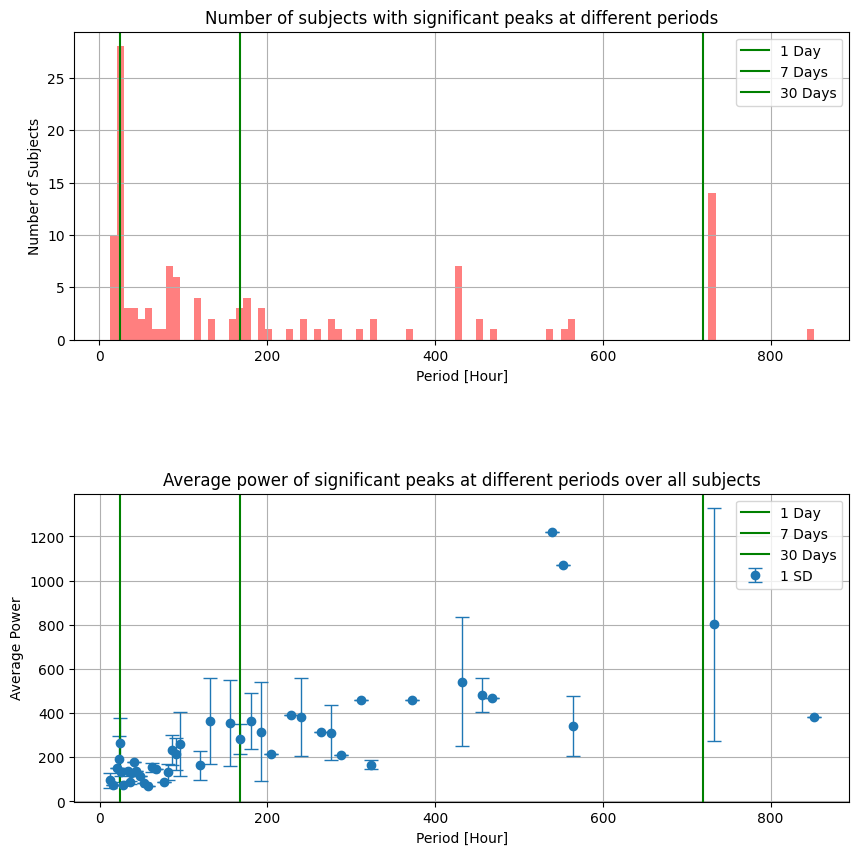

In [10]:
plot_peak_power_dist(all_peaks_dict, all_power_dict)